# **Fastai - Transfer Learning (for computer vision) - Adv Settings**

As always, first check if you have your GPU accelerator in Colab enabled.
Second, run the cells below to activate the helper functions of fastai, and link it to GDrive.


In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.6 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
from fastbook import *

We're going to level up from our cats&dogs dataset, and use the pets dataset (http://www.robots.ox.ac.uk/~vgg/data/pets/) build into fastai. This is a more challenging problem: figuring out what breed of pet is in the image! There are 7400 different images, 26 different dog breeds, and 12 different cat breeds.

Yeah baby! This a challenging dataset (not really...it used to be...now it's pretty standard, if you use transfer learning)

Ofcourse, you can also use your own dataset (see notebook from last week) to experiment with the code below

In [3]:
path = untar_data(URLs.PETS)

In [4]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_180.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_55.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/samoyed_105.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_119.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_5.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_118.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_109.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_79.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_80.jpg')...]

Okay. So we have close to 7400 images....

As we covered in the previous lesson and notebooks, first step is to create a DataBlock, so we have a template for the dataloader.

In [5]:
catdogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # the line of code below is just using Regular Expressions to link a file to a label
    # the label, the breed of the pet, is in the filename, that's why we need a regex to extract it as the label
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    # now let's also add some awesome augmentation (presizing) into the mix as well
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

So far, everything should look familiar to everybody. It's the same thing as in the previous lesson. Only the last 2 lines of the DataBlock are a little bit different...

Fastai has a really powerfull augmentation technique, called Presizing.
It has 2 steps: first resize your images to relatively large dimensions (higher than the target training dimensions), and then compose all common augmentation operations (rotating, cropping, flipping,..., including a final resizing of the result) all into one, and perform it all as a combined parallel operation on the GPU (so not doing everything sequentially one by one).
This way speeds up things by a lot, and the initial 'oversizing' enables fastai to get away with fast operations without dealing with pesky margin errors, problems on the edge of images, etc. It's just a quick and dirty way around those problems, and it seems to work really really well!

The library does it all for us, in just a few more arguments in the datablock call...

Sweet!!!


In [6]:
dls = catdogs.dataloaders(path/"images")

By default, fastai will load 64 images at a time, stacked up as one big multidimensional tensor. So default batch_size = 64.

And, as always, let's do a quick sanity check of our data

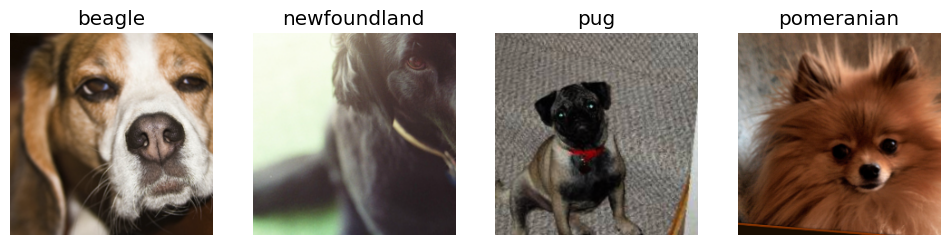

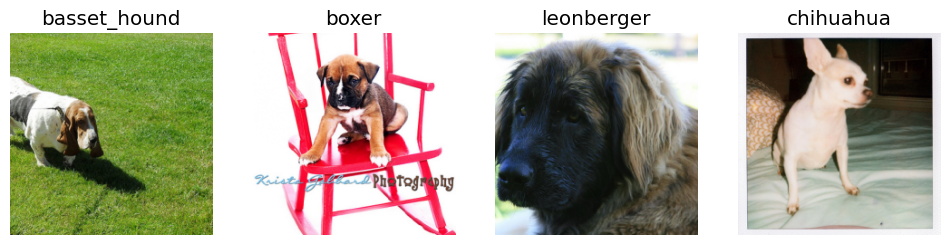

In [7]:
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

Awesome! Now we're cooking!

The fastai library did already some of its magic, and created the **dls object** with training and validation data ready to go!

# **Fastai Computer Vision Zoo:**

As we've covered in the conceptual part of the course, there are lots of awesome pretrained CNN networks available. The go-to standard of today, is still the **resnet architecture**.

Ofcourse, resnet can be a very deep architecture, requiring lots of memory to load. So it might a problem if you want to deploy it on edge devices, but in a cloud environment (GCP, Colab), or on our own laptop, this shouldn't be a big issue.

Note: look at the logs below when you download an architecture: for instance: alexnet = **233MB** in size... So, watch out if you ever want to deploy it on a device with limited resources.



Let's play around with different architecture we've covered in class:

*Note: we're only going to fine-tune for 1 iteration, because otherwise it would take way too long. Fine_tuning in this context actually means: **fit_one_cycle, unfreeze, and fit_one_cycle**. It uses default values for a couple of parameters, for instance the learning rate. Later in the notebook we'll dive into those details.*


# **Alexnet**

In [8]:
alex_model = vision_learner(dls, alexnet, metrics=error_rate)
alex_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 91.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.584265,0.951550,0.284844,01:12


epoch,train_loss,valid_loss,error_rate,time
0,1.255394,0.721591,0.224628,01:10


# **VGG**

We'll only run vgg16 here, because it's already pretty large. Fastai also has support for vgg19_bn (bn stands for: adding batch normalization layers to the standard version of the vgg architecture)

In [9]:
vgg16_model = vision_learner(dls, vgg16_bn, metrics=error_rate)
vgg16_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 93.3MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.683782,0.388501,0.130582,01:33


epoch,train_loss,valid_loss,error_rate,time
0,0.529493,0.245174,0.080514,02:02


# **Resnet**

We'll run a Resnet50 below, but fastai also has support for: resnet18, resnet34, resnet101, and resnet152. You can try them out yourselve.

In [10]:
resnet50_model = vision_learner(dls, resnet50, metrics=error_rate)
resnet50_model.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 24.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.475421,0.359193,0.112991,01:23


epoch,train_loss,valid_loss,error_rate,time
0,0.394749,0.254652,0.081191,01:30


It all depends on what kind of data you have, but usually the resnet architecture is the go-to option. So let's explore this one a little bit further. Ofcourse, for your assignment you can try different architectures as well. See which one best fits your needs...

# **Model Performance**

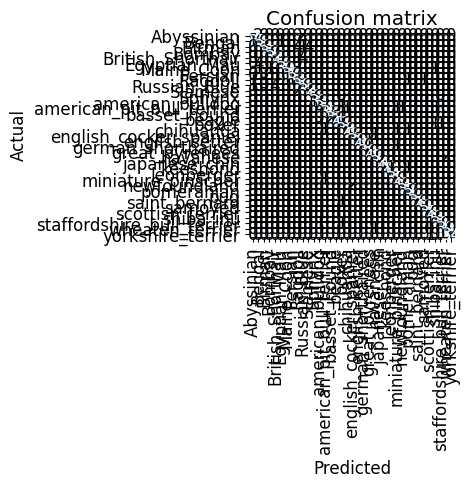

In [11]:
interp = ClassificationInterpretation.from_learner(resnet50_model)
interp.plot_confusion_matrix()

Okay, my bad. I wasn't thinking. This dataset is little bit too big for a general confusion matrix, because there are like 37 different categories...
Let's try that again...

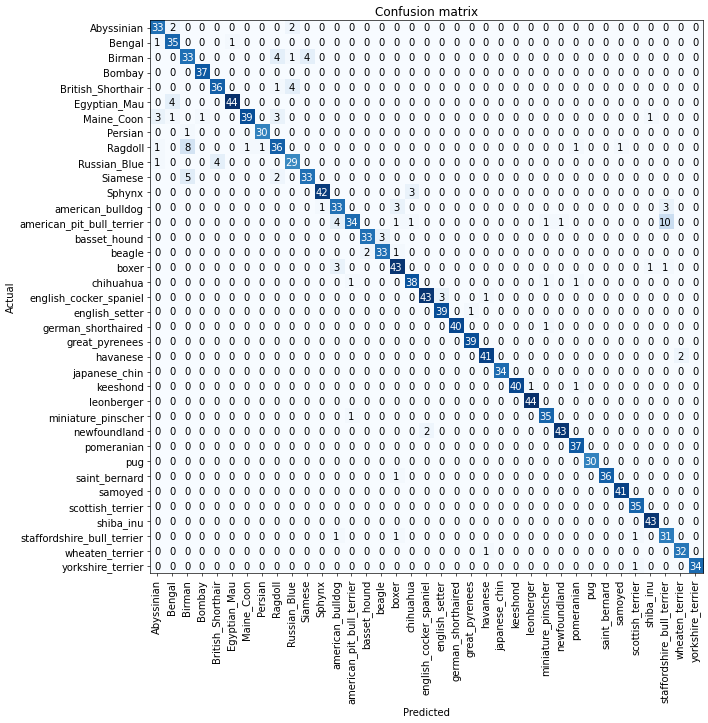

In [12]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

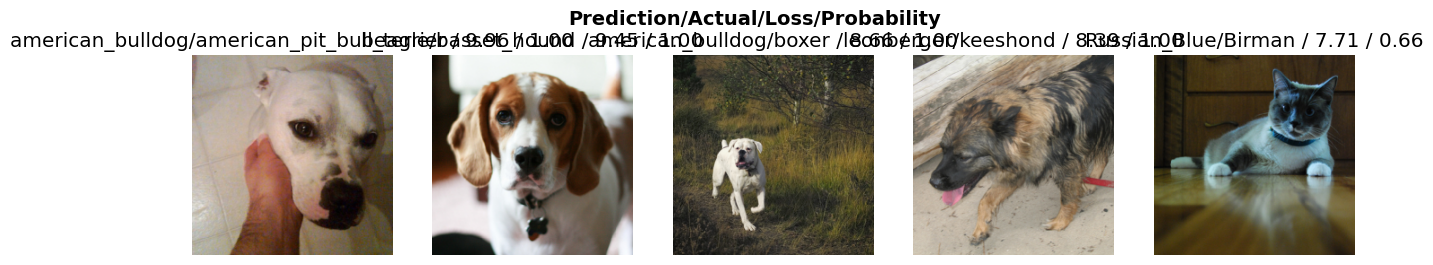

In [13]:
interp.plot_top_losses(5, nrows=1)

In [14]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Ragdoll', 'Birman', 8),
 ('Siamese', 'Birman', 5)]

# **Improving Our Model**

Now let's take it one step further. Let's dive into transfer learning and how to fine-tune our pretrained model as best as possible, without breaking the pretrained weights.

The first thing we need to set when training a model is the **learning rate**. We saw in the previous lesson that it needs to be just right to train as efficiently as possible, so how do we pick a good one? fastai provides a tool for this.

**The Learning Rate Finder**

One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

So let's just make our learning rate really high, right? Sure, let's try that and see what happens:

In [15]:
resnet34_overtrain = vision_learner(dls, resnet34, metrics=error_rate)
resnet34_overtrain.fine_tune(1, base_lr=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.603725,5.404843,0.489851,01:14


epoch,train_loss,valid_loss,error_rate,time
0,4.168288,2.779829,0.794317,01:13


That doesn't look good. Here's what happened: the optimizer stepped in the correct direction, but it stepped so far that it totally overshot the minimum loss. Repeating that multiple times makes it get further and further away, not closer and closer!
(BTW if we didn't specify the learning rate manually, the default would have been used, i.e. 1e-3 (0.001))

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the *learning rate finder*.

The tool will do a 'quick search', using the chosen architecture and data, to try and find the best learning rate (where the loss goes down the most, the steepest part (highest gradient), and hopefully as far right as possible, because a higher learning rate equals faster learning)


SuggestedLRs(valley=0.0012022644514217973)

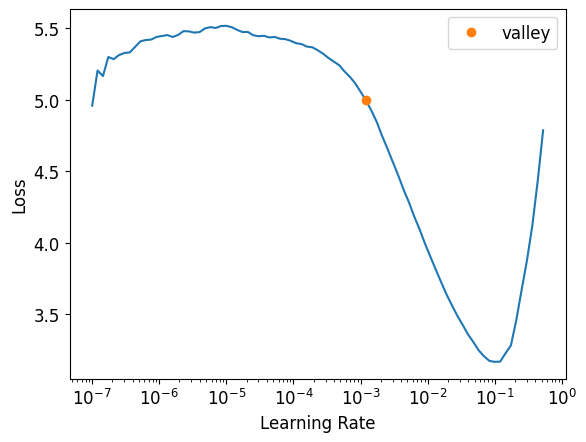

In [26]:
resnet34_just_right = vision_learner(dls, resnet34, metrics=error_rate)
resnet34_just_right.lr_find()

In this situation, the tool will probably suggest something between 0.001 and 0.01. It depends on the quick search. You can check this by running the code block above a couple more times. You'll notice that the suggested LR will change a little bit each time.

You can also see that a learning rate around the 0.1 mark is really dangerous. That's the point our loss tends to shoot up, and make our learning very unstable.

# **Unfreezing & Transfer Learning**

When we create a model from a pretrained network, fastai automatically freezes all of the pretrained layers for us. When we call the fine_tune method fastai does 2 things:

1.   Trains the randomly added layers for one epoch, with all other layers frozen.
2.   Unfreezes all of the layers, and trains them **all** for the number of epochs requested.

Although this is a reasonable default approach, it is likely that for your particular dataset you may get better results by doing things slightly different.

Let's do it ourselves. We won't be using the fine_tune function, but manually activate fit_one_cycle (for 1 or more epochs), unfreeze the resnet, and again fit_one_cycle for a couple of epochs (now traing the entire thing, not just the final layers:

What fit_one_cycle does, is to start training at a low learning rate, gradually increase it for the first section of training, and then gradually decrease it again for the last section of training. We've covered this concept last week (learning rate annealing, learning rate schema)

In [17]:
resnet_adv = vision_learner(dls, resnet34, metrics=error_rate)
resnet_adv.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.144004,0.305675,0.103518,01:16
1,0.519097,0.245543,0.078484,01:14
2,0.312166,0.212574,0.066982,01:14


In [18]:
resnet_adv.unfreeze()

Let's run `lr_find` again, because having more layers to train, and weights that have already been trained for three epochs, means our previously found learning rate isn't appropriate any more:

SuggestedLRs(valley=2.511886486900039e-05)

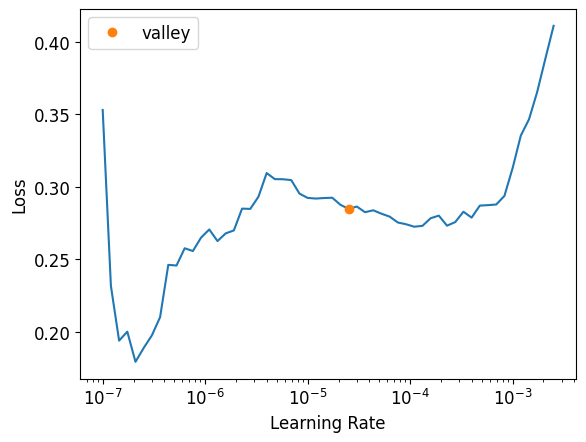

In [19]:
resnet_adv.lr_find()

Note that the graph is a **little different** from when we had random weights: we don't have that sharp descent that indicates the model is training. That's because our model has been trained already. So finding a good learning rate isn't that straightforward anymore...

In [20]:
resnet_adv.fit_one_cycle(6, 1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.261206,0.203791,0.062246,01:17
1,0.249697,0.198735,0.059540,01:21
2,0.224870,0.193682,0.056834,01:15
3,0.194822,0.191244,0.058187,01:14
4,0.185978,0.189525,0.056834,01:16
5,0.174144,0.186683,0.054127,01:17


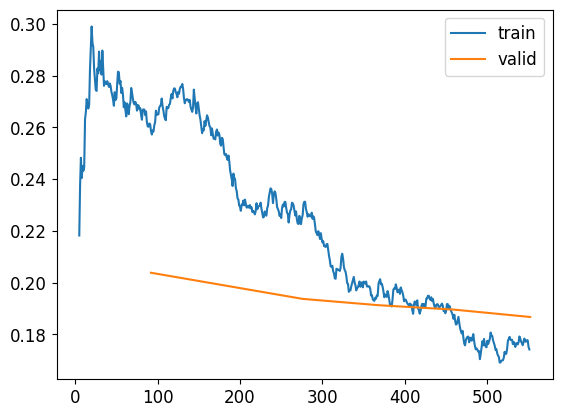

In [21]:
resnet_adv.recorder.plot_loss()

Okay. Can we do some more advanced tweaking?

# Discriminative learning rates
Ofcourse! We could use **discriminative learning rates**. So, use a one_cycle aproach for the learning rate, but not every layer of our deeply layered network should use the same learning rate to learn. It's the same general concept as with one_cycle, but now, we don't want to really mess up those carefully trained weights in the early, transferred, layers.

We just want to tweak them a little, ietsy bitsy tiny bit, but if we get deeper and deeper into our network (so closer to the output, we can do a little bit more tweaking, and a little bit more,)... That's why we use a slice, to determine to 'tweaking range', spread out over our layers.

The general idea again, is: train earlier layer(s) with super low learning rate, and train later layers with higher learning rate. The idea is to not drastically alter the almost-perfect pre-trained weights except for minuscule amounts, and to be more aggressive with teaching the layers near the outputs.

In [22]:
resnet_really_adv = vision_learner(dls, resnet34, metrics=error_rate)
resnet_really_adv.fit_one_cycle(3, 3e-3)
resnet_really_adv.unfreeze()
resnet_really_adv.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.140300,0.365813,0.116373,01:17
1,0.516065,0.225916,0.075101,01:11
2,0.328688,0.211424,0.072395,01:15


epoch,train_loss,valid_loss,error_rate,time
0,0.259669,0.210839,0.071042,01:17
1,0.246580,0.201385,0.063599,01:14
2,0.240520,0.195521,0.062923,01:18
3,0.216893,0.187104,0.058863,01:16
4,0.199284,0.192267,0.064276,01:16
5,0.176743,0.188789,0.060893,01:16
6,0.164249,0.192713,0.058187,01:12
7,0.134940,0.184780,0.058863,01:18
8,0.144817,0.182706,0.056157,01:16
9,0.130391,0.186605,0.059540,01:16


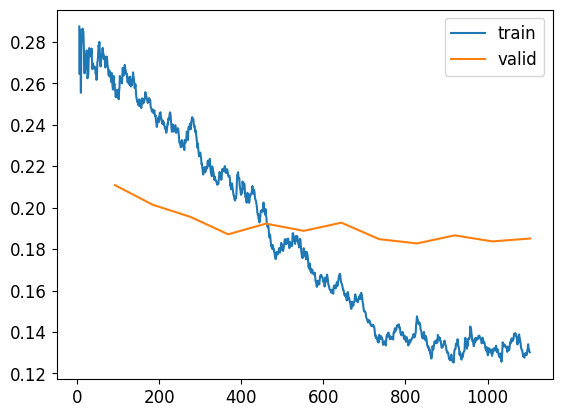

In [23]:
resnet_really_adv.recorder.plot_loss()

Can we go even further in our tweaking?

Yes, we can!

# Mixed precision training

**FP16 to the rescue to speed things up!**

The downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot, is mixed-precision training. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training. This technique can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add to_fp16() after your Learner creation (you also need to import the module).

You can't really know ahead of time what the best architecture for your particular problem is—you need to try training some. So let's try a ResNet-50 now with mixed precision:

In [24]:
from fastai.callback.fp16 import *
resnet_adv_tweaked = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
resnet_adv_tweaked.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,2.201883,0.453959,0.138024,01:15
1,0.841491,0.290497,0.091340,01:12
2,0.560383,0.254949,0.087957,01:09


epoch,train_loss,valid_loss,error_rate,time
0,0.301280,0.241499,0.077808,01:14
1,0.241276,0.242569,0.074425,01:14
2,0.193566,0.250499,0.075101,01:15
3,0.150065,0.211724,0.066982,01:13
4,0.087854,0.207154,0.060217,01:14
5,0.065046,0.196196,0.054127,01:12


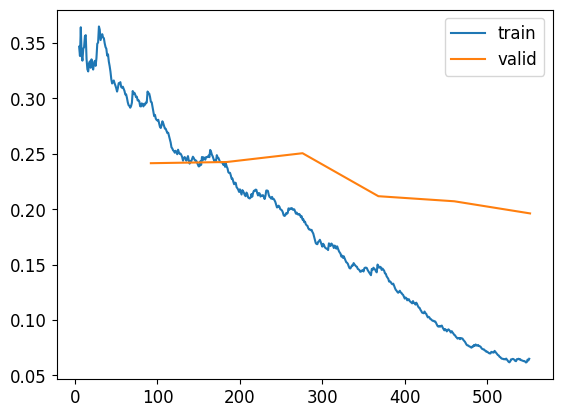

In [25]:
resnet_adv_tweaked.recorder.plot_loss()

You've probably noticed, that here we've gone back to using the general **fine_tune**, since it's so handy! We can pass freeze_epochs to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets.

Need! But euhm...maybe we're overtraining now..., or not? Because our valid error is still going down. Yes, our training error is going down faster, but the validation error isn't climbing...so...I think we just need to do some more training, because, as long as valid error doesn't go up, no harm no foul? Right? (retorical question: think about it)

As we saw in the previous lesson, we can ofcourse save our model, when we think our model is good enough. Or when you had to train it for a long time, and you don't want to do that over and over again... ;-)
Remember: you can save your model, but also serialize it into a pickle file.
This pickle file can than be used to deploy your model in a web setting.


Have fun!